In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix

In [427]:
def linear(x, a, b):
    return a*x + b

 ### First order backward difference method

In [614]:
def A_b(x, h = 5.0, U = 5, T_0 = 0.6, T_b = 1.2):
    n = len(x)
    A = np.eye(n)
    delta_x = x[1] - x[0]
    diag = U/delta_x + 2 * h
    diag_1 = -U/delta_x
    for i in range(1, n):
        A[i][i] = diag
        A[i][i-1] = diag_1
        
    b = np.zeros(n)
    b[0] = T_0
    b[1:] = 2 * h * T_b
    return(A, b)

In [615]:
x = np.arange(0, 1, 0.01)
A, b = A_b(x)
T = np.linalg.solve(A, b)
T_exact = 1.2 - 0.6 * np.exp(-2 * x)

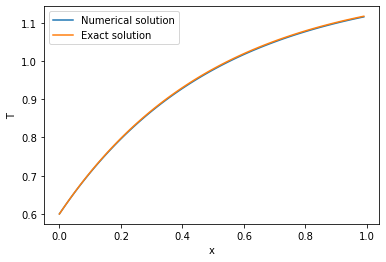

In [616]:
plt.plot(x, T, label = 'Numerical solution')
plt.xlabel('x')
plt.ylabel('T')
plt.plot(x, T_exact, label = 'Exact solution')
plt.legend()

### Second order backward difference method

In [5]:
def A_b_2(x, h = 5.0, U = 5, T_0 = 0.6, T_b = 1.2):
    n = len(x)
    A = np.eye(n)
    delta_x = x[1] - x[0]
    diag = 1.5 * U/delta_x + 2 * h
    diag_1 = -2 * U/delta_x
    diag_2 = 0.5 * U/delta_x
    for i in range(2, n):
        A[i][i] = diag
        A[i][i-1] = diag_1
        A[i][i-2] = diag_2
    A[1][0] = - U/delta_x
    A[1][1] = U/delta_x + 2 * h
    b = np.zeros(n)
    b[0] = T_0
    b[1:] = 2 * h * T_b
    return(A, b)

In [6]:
x = np.arange(0, 1, 0.01)
A, b = A_b_2(x)
T = np.linalg.solve(A, b)
T_exact = 1.2 - 0.6 * np.exp(-2 * x)

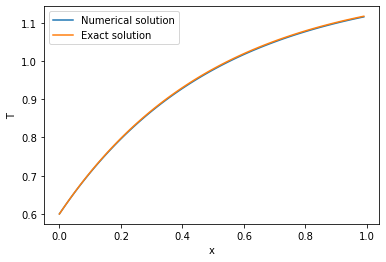

In [617]:
plt.plot(x, T, label = 'Numerical solution')
plt.xlabel('x')
plt.ylabel('T')
plt.plot(x, T_exact, label = 'Exact solution')
plt.legend()

### Order of convergence

In [619]:
error = 1
n = 11
error_1, error_2, delta_x_1, delta_x_2 = [], [], [], []
while error > 0.0001:
    x = np.linspace(0, 1, n)
    
    A, b = A_b(x)
    T_1 = np.linalg.solve(A, b)
    T_exact = 1.2 - 0.6 * np.exp(-2 * x)
    error = (np.linalg.norm(T_1 - T_exact)) / (n-1)**0.5
    error_1.append(error)
    
    delta_x_1.append(1/(n-1))
    n = 2*n - 1
    
error = 1
n = 11
while error > 0.0001:
    x = np.linspace(0, 1, n)
    
    A, b = A_b_2(x)
    T_2 = np.linalg.solve(A, b)
    T_exact = 1.2 - 0.6 * np.exp(-2 * x)
    error = np.linalg.norm(T_2 - T_exact) / (n-1)**0.5
    error_2.append(error)
    
    delta_x_2.append(1/(n-1))
    n = 2*n -1

Order of convergence for the first method = 1


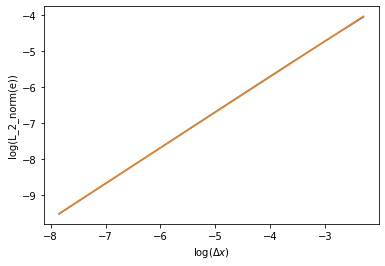

Order of convergence for the first method = 2


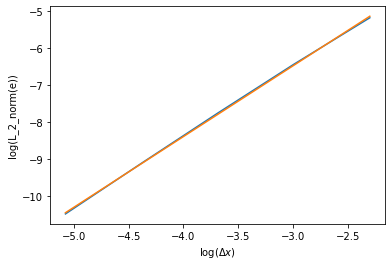

In [620]:
coef_1 = curve_fit(linear, np.log(delta_x_1), np.log(error_1))[0]
plt.plot(np.log(delta_x_1), np.log(error_1))
plt.plot(np.log(delta_x_1), linear(np.log(delta_x_1), *coef_1))
plt.xlabel('log($\Delta x$)')
plt.ylabel('log(L_2_norm(e))')
print('Order of convergence for the first method = ' + str(round(coef_1[0])))
plt.show()
coef_2 = curve_fit(linear, np.log(delta_x_2), np.log(error_2))[0]
plt.plot(np.log(delta_x_2), np.log(error_2))
plt.plot(np.log(delta_x_2), linear(np.log(delta_x_2), *coef_2))
print('Order of convergence for the first method = ' + str(round(coef_2[0])))
plt.xlabel('log($\Delta x$)')
plt.ylabel('log(L_2_norm(e))')
plt.show()

### Thermal part 1.2.6

In [621]:
def Heat(N_xi, N_eta, T_hot, T_cool, h, geom):

    L  = geom[0]
    L0 = geom[1]
    L1 = geom[2]
    L2 = geom[3]

    d_xi  = 1/(N_xi-1)
    d_eta = 1/(N_eta-1)

    # Create uniform grid in computational space
    xi, eta = np.meshgrid(np.linspace(0,1,N_xi), np.linspace(0,1,N_eta), indexing='ij')

    # Create map (i,j) -> I (index in global matrix)
    TotalNodes = N_xi*N_eta
    Node = np.arange(0,TotalNodes).reshape((N_xi,N_eta), order='F')

    # Allocate space for right hand side vector and global matrix.
    # Make sure to use a sparse matrix format (here we use list of lists (lil)
    A = lil_matrix((TotalNodes, TotalNodes))
    RHS = np.zeros(TotalNodes)

    # Construct A

    # First loop over interior nodes
    for i in range(1,N_xi-1):
        for j in range(1,N_eta-1):
            CN = Node[i,j]   # Current node

            # Calculate mapping coefficients
            c_xixi = 1
            c_etaeta = ((0.2 * j*d_eta)**2 + 1) / ((0.25 - 0.2*i*d_xi)**2)
            c_xieta = (0.4 * j*d_eta) / (0.25 - 0.2*i*d_xi)
            c_eta = 2 * (0.2)**2 * j*d_eta / ((0.25 - 0.2*i*d_xi)**2)

            # Stamp entries in global matrix
            A[CN, Node[i+1,j  ]] = A[CN, Node[i+1,j  ]] + 1/d_xi**2 * c_xixi
            A[CN, Node[i  ,j  ]] = A[CN, Node[i  ,j  ]] - 2/d_xi**2 * c_xixi - 2/d_eta**2 * c_etaeta
            A[CN, Node[i-1,j  ]] = A[CN, Node[i-1,j  ]] + 1/d_xi**2 * c_xixi
            
            A[CN, Node[i  ,j+1]] = A[CN, Node[i  ,j+1]] + 1/d_eta**2 * c_etaeta + 1/(2*d_eta) * c_eta
            A[CN, Node[i  ,j-1]] = A[CN, Node[i  ,j-1]] + 1/d_eta**2 * c_etaeta - 1/(2*d_eta) * c_eta

            A[CN, Node[i+1,j+1]] = A[CN, Node[i+1,j+1]] + 1/(4*d_eta*d_xi) * c_xieta  
            A[CN, Node[i+1,j-1]] = A[CN, Node[i+1,j-1]] - 1/(4*d_eta*d_xi) * c_xieta   
            A[CN, Node[i-1,j+1]] = A[CN, Node[i-1,j+1]] - 1/(4*d_eta*d_xi) * c_xieta  
            A[CN, Node[i-1,j-1]] = A[CN, Node[i-1,j-1]] + 1/(4*d_eta*d_xi) * c_xieta 

            
    # Now boudnary conditions
    for i in range(N_xi):     # Bottom boundary
        CN = Node[i,0]

        # Calculate mapping coefficients and normal vector
        
        c_eta =  0.5 / (0.25-0.2*i*d_xi) /d_eta

        A[CN, Node[i,0]] = A[CN, Node[i,0]] - 3 * c_eta - h
        A[CN, Node[i,1]] = A[CN, Node[i,1]] + 4 * c_eta 
        A[CN, Node[i,2]] = A[CN, Node[i,2]] - 1 * c_eta
       
        RHS[CN] = - h * T_cool[i]

    for i in range(N_xi):     # Top boundary
        CN = Node[i,N_eta-1]
        
        n_x = -1/26**0.5
        n_y = -5/26**0.5
        
        c_eta = (n_x*0.2 + n_y) / (0.25-0.2*i*d_xi) * 0.5 / d_eta
        c_xi = n_x * 0.5/d_xi

        if i == 0:   # Corner node
            A[CN, Node[0,N_eta-1]] = A[CN, Node[0,N_eta-1]] + 3 * c_eta - 3 * c_xi - h
            A[CN, Node[1,N_eta-1]] = A[CN, Node[1,N_eta-1]] + 4 * c_xi
            A[CN, Node[2,N_eta-1]] = A[CN, Node[2,N_eta-1]] - 1 * c_xi
            A[CN, Node[0,N_eta-2]] = A[CN, Node[0,N_eta-2]] - 4 * c_eta
            A[CN, Node[0,N_eta-3]] = A[CN, Node[0,N_eta-3]] + 1 * c_eta
            
        elif i == N_xi-1:    # Corner node
            A[CN, Node[N_xi-1, N_eta-1]] = A[CN, Node[N_xi-1, N_eta-1]] + 3 * c_eta + 3 * c_xi - h
            A[CN, Node[N_xi-2, N_eta-1]] = A[CN, Node[N_xi-2, N_eta-1]] - 4 * c_xi
            A[CN, Node[N_xi-3, N_eta-1]] = A[CN, Node[N_xi-3, N_eta-1]] + 1 * c_xi
            A[CN, Node[N_xi-1,N_eta-2]] = A[CN, Node[N_xi-1,N_eta-2]] - 4 * c_eta
            A[CN, Node[N_xi-1,N_eta-3]] = A[CN, Node[N_xi-1,N_eta-3]] + 1 * c_eta
            
        else:   
            A[CN, Node[i,N_eta-1]] = A[CN, Node[i,N_eta-1]] + 3 * c_eta - h
            A[CN, Node[i+1,N_eta-1]] = A[CN, Node[i+1,N_eta-1]] + 1 * c_xi
            A[CN, Node[i-1,N_eta-1]] = A[CN, Node[i-1,N_eta-1]] - 1 * c_xi
            A[CN, Node[i,N_eta-2]] = A[CN, Node[i,N_eta-2]] - 4 * c_eta
            A[CN, Node[i,N_eta-3]] = A[CN, Node[i,N_eta-3]] + 1 * c_eta

        RHS[CN] = - h * T_hot
        
    for j in range(1,N_eta-1):  # Left boundary
        CN = Node[0,j]
        c_eta = 4/5*j*d_eta*0.5/d_eta
        c_xi = 0.5/d_xi
        
        A[CN, Node[0,j]] = A[CN, Node[0,j]] - 3 * c_xi
        A[CN, Node[1,j]] = A[CN, Node[1,j]] + 4 * c_xi
        A[CN, Node[2,j]] = A[CN, Node[2,j]] - 1 * c_xi
        A[CN, Node[0,j+1]] = A[CN, Node[0,j+1]] + 1 * c_eta
        A[CN, Node[0,j-1]] = A[CN, Node[0,j-1]] - 1 * c_eta
        
        RHS[CN] = 0

    for j in range(1,N_eta-1):  # Right boundary
        
        CN = Node[N_xi-1,j]
        c_eta = - 4*j*d_eta
        c_xi = - 1
        
        A[CN, Node[N_xi-1,j]] = A[CN, Node[N_xi-1,j]] + 3/(2*d_xi) * c_xi - h
        A[CN, Node[N_xi-2,j]] = A[CN, Node[N_xi-2,j]] - 4/(2*d_xi) * c_xi
        A[CN, Node[N_xi-3,j]] = A[CN, Node[N_xi-3,j]] + 1/(2*d_xi) * c_xi
        A[CN, Node[N_xi-1,j+1]] = A[CN, Node[N_xi-1,j+1]] + 1/(2*d_eta) * c_eta
        A[CN, Node[N_xi-1,j-1]] = A[CN, Node[N_xi-1,j-1]] - 1/(2*d_eta) * c_eta
        
        RHS[CN] = - h * T_hot
    #plt.pcolor(A.toarray())

    # Compute solution and resahpe
    T = spsolve(A.tocsr(),RHS).reshape((N_xi,N_eta), order='F')

    return T

In [622]:
#   See figure 1 for defintiions of L, L0, L1 and L2                         
L = 1
L1 = 0.25
L0 = 0.025
L2 = 0.05

T_hot = 1.4
T_cool_inlet = 0.6
h = 5.0

N_xi = 51
N_eta = 31

U = 5.0

# Start with a uniform temperature in the cooling passage
T_cool = T_cool_inlet*np.ones(N_xi)

# Solve for the blade temperature distribution
T = Heat(N_xi, N_eta, T_hot, T_cool, h, [L, L0, L1, L2])

# Using T(:,1) solve for temperature on the cooling fluid
d_xi  = 1/(N_xi-1)

# xx = np.linspace(0, 1, 81)
# A, b = A_b_2(xx, T_b = T[:, 0])
# T_cool = np.linalg.solve(A, b)


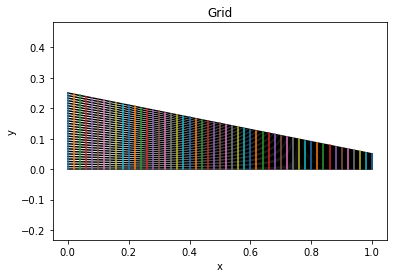

<ipython-input-623-82f8982d7610>:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x, y, T, shading='auto')


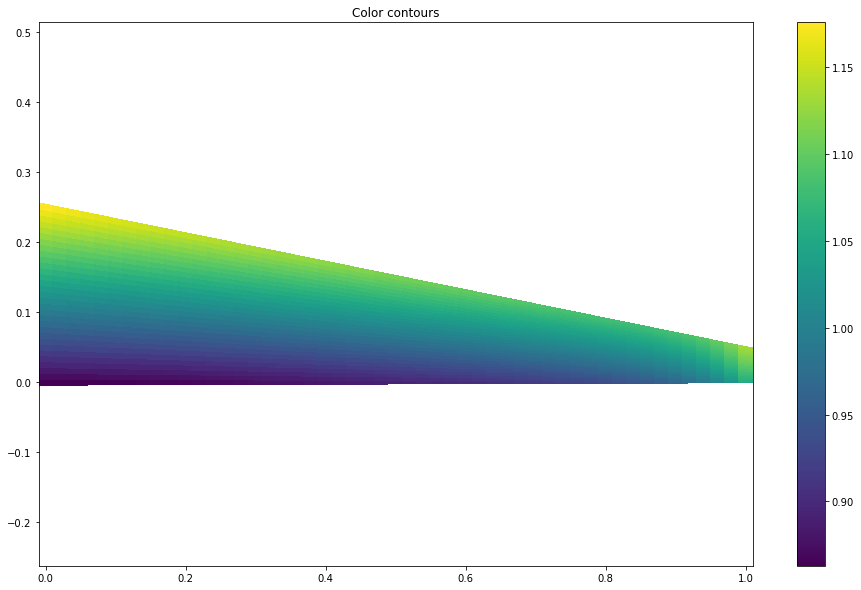

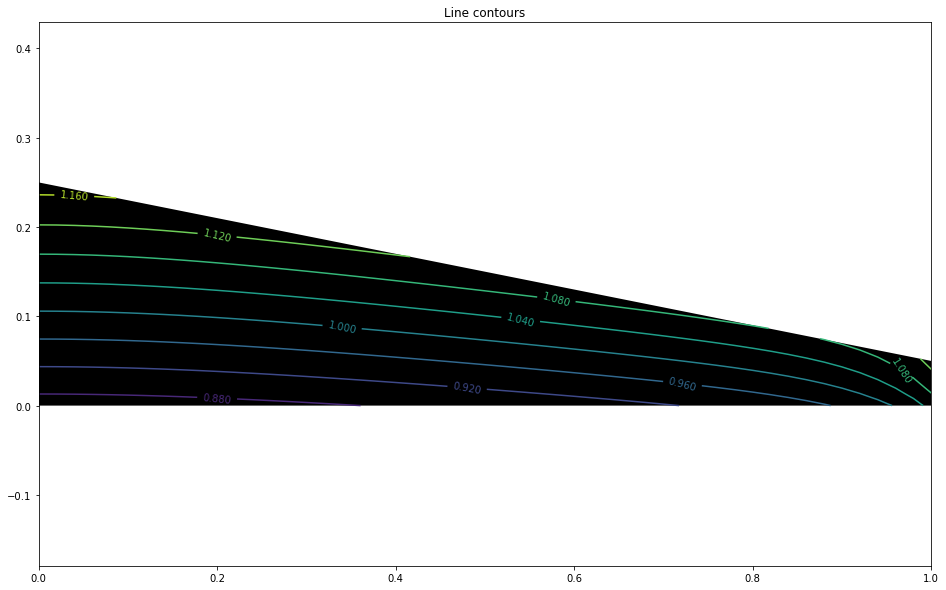

In [623]:
#==================================================================================
#   Basic plotting (need to include axis labels etc...)
#==================================================================================
xi, eta = np.meshgrid(np.linspace(0,1,N_xi), np.linspace(0,1,N_eta), indexing='ij')
x = xi
y = 0.25*eta - 0.2*xi*eta

#  Plot grid
plt.figure(1)
plt.plot(x, y, 'k')
plt.title('Grid')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(np.transpose(x), np.transpose(y))
plt.axis('equal')
plt.show()

#   Plot color contours
plt.figure(2, figsize = (16, 10))
plt.title('Color contours')
plt.pcolormesh(x, y, T, shading='auto')
plt.colorbar()
plt.axis('equal')
plt.show()

#   Plot line contours
plt.figure(3, figsize = (16, 10))
plt.title('Line contours')
xc = [x[0,0], x[N_xi-1,0], x[N_xi-1,N_eta-1], x[0,N_eta-1], x[0,0]]
yc = [y[0,0], y[N_xi-1,0], y[N_xi-1,N_eta-1], y[0,N_eta-1], y[0,0]]
plt.fill(xc,yc, 'k')
CS = plt.contour(x, y, T)
plt.clabel(CS, inline=True, fontsize=10)
plt.axis('equal')
plt.show()

# #   Plot T_cool
# plt.figure(4)
# plt.plot(np.linspace(0, 1, N_xi), T_cool, 'k')
# plt.show()

Our results are in good agreement with Fig. 4.

### 1.3 Thermal Fluid Coupling

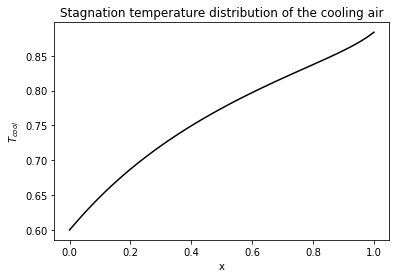

In [625]:
#print(T[1:, 0])
A, b = A_b_2(x[:, 0], T_b = T[1:, 0])
T_fluid = np.linalg.solve(A, b)
#   Plot T_cool
plt.figure(4)
plt.title('Stagnation temperature distribution of the cooling air')
plt.xlabel('x')
plt.ylabel('$T_{cool}$')
plt.plot(np.linspace(0, 1, N_xi), T_fluid, 'k')
plt.show()

In [629]:
T_hot = 1.4
T_cool_inlet = 0.6
h = 5.0

N_xi = 81
N_eta = 41

U = 5.0
T_cool = T_cool_inlet*np.ones(N_xi)

xi, eta = np.meshgrid(np.linspace(0,1,N_xi), np.linspace(0,1,N_eta), indexing='ij')
x = xi
y = 0.25*eta - 0.2*xi*eta

for i in range(1000):
    T_cur = Heat(N_xi, N_eta, T_hot, T_cool, h, [L, L0, L1, L2])
    A, b = A_b_2(x[:, 0], T_b = T_cur[1:, 0])
    T_fluid = np.linalg.solve(A, b)
    if (((T_cool-T_fluid)**2).sum())**0.5 < 1e-7:
        print('we have converged!')
        break
    T_cool = T_fluid

we have converged!


<ipython-input-632-46c31e811719>:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x, y, T_cur, shading='auto')


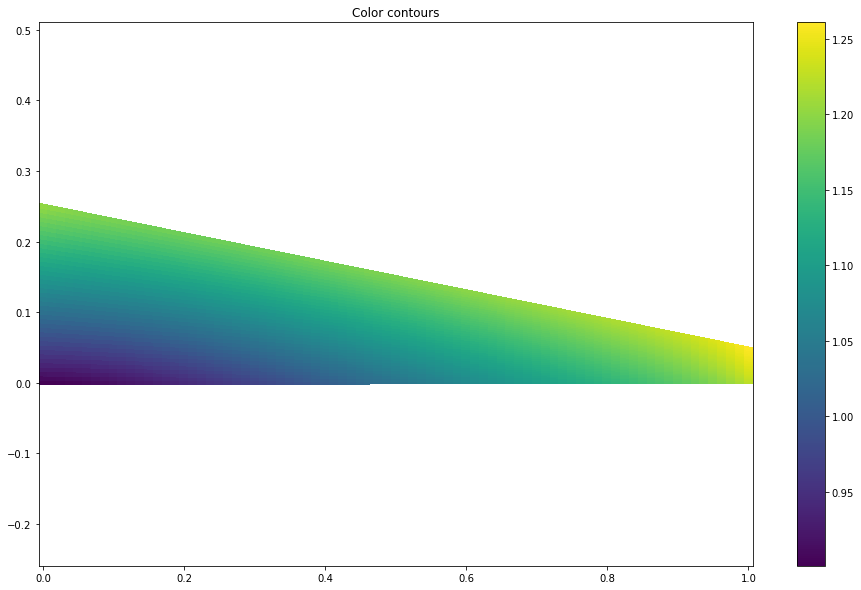

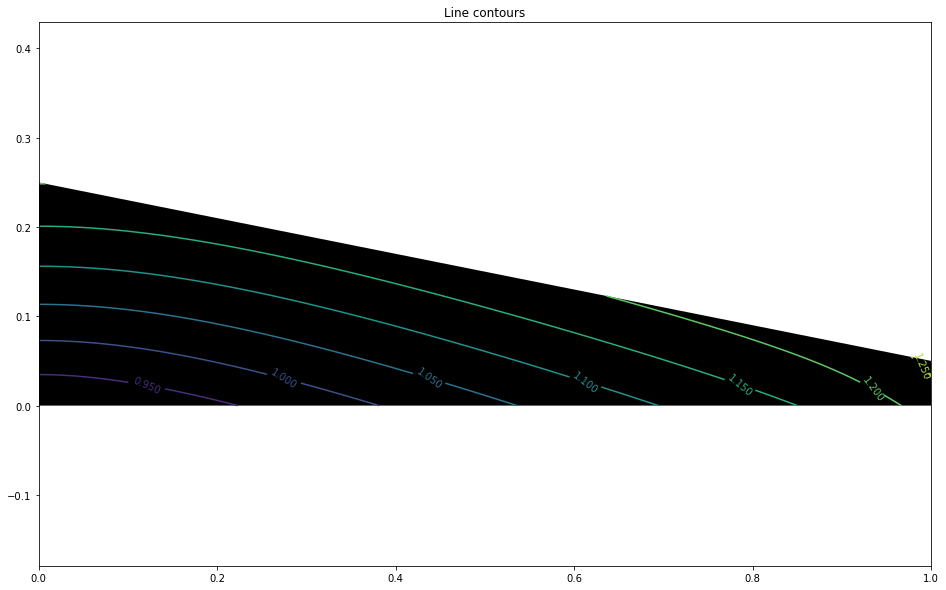

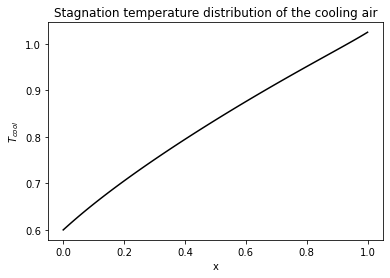

In [632]:
xi, eta = np.meshgrid(np.linspace(0,1,N_xi), np.linspace(0,1,N_eta), indexing='ij')
x = xi
y = 0.25*eta - 0.2*xi*eta

#   Plot color contours
plt.figure(2, figsize = (16, 10))
plt.title('Color contours')
plt.pcolormesh(x, y, T_cur, shading='auto')
plt.colorbar()
plt.axis('equal')
plt.show()

#   Plot line contours
plt.figure(3, figsize = (16, 10))
plt.title('Line contours')
xc = [x[0,0], x[N_xi-1,0], x[N_xi-1,N_eta-1], x[0,N_eta-1], x[0,0]]
yc = [y[0,0], y[N_xi-1,0], y[N_xi-1,N_eta-1], y[0,N_eta-1], y[0,0]]
plt.fill(xc,yc, 'k')
CS = plt.contour(x, y, T_cur)
plt.clabel(CS, inline=True, fontsize=10)
plt.axis('equal')
plt.show()

#   Plot T_cool
plt.figure(4)
plt.title('Stagnation temperature distribution of the cooling air')
plt.xlabel('x')
plt.ylabel('$T_{cool}$')
plt.plot(np.linspace(0, 1, N_xi), T_cool, 'k')
plt.show()

In [634]:
max_T = np.max(T_cur)
print(max_T)

1.261138866743226


The maximum temperature on the blade is 1.26 and it occurs at the top right corner of the blade.

In [635]:
T_hot = 1.4
T_cool_inlet = 0.6
h = 5.0

N_xi = 81
N_eta = 41

U_list = np.arange(2.5, 21, 2.5)
T_cool = T_cool_inlet*np.ones(N_xi)

xi, eta = np.meshgrid(np.linspace(0,1,N_xi), np.linspace(0,1,N_eta), indexing='ij')
x = xi
y = 0.25*eta - 0.2*xi*eta

max_T_list = []

for U in U_list:
    for i in range(1000):
        T_cur = Heat(N_xi, N_eta, T_hot, T_cool, h, [L, L0, L1, L2])
        A, b = A_b_2(x[:, 0], U = U, T_b = T_cur[1:, 0])
        T_fluid = np.linalg.solve(A, b)
        if (((T_cool-T_fluid)**2).sum())**0.5 < 1e-7:
            print('we have converged!')
            max_T_list.append(np.max(T_cur))
            break
        T_cool = T_fluid

we have converged!
we have converged!
we have converged!
we have converged!
we have converged!
we have converged!
we have converged!
we have converged!


Text(0, 0.5, 'Maximum temperature on the blade')

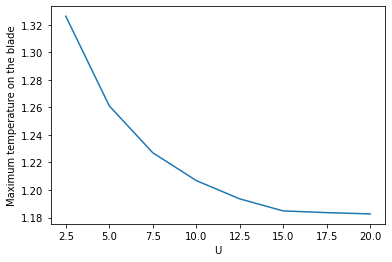

In [637]:
plt.plot(U_list, max_T_list)
plt.xlabel("U")
plt.ylabel('Maximum temperature on the blade')

As U increases, maximum temperature on the blade decreases. We were expecting this result, since with increasing U the cool flow spends less time eqilibrating with the blade and therefore, it's less hot when it reaches the end of the blade, making the maximum tempereture on the blade decrease.

## Part 2. Iteration methods

In [639]:
def Jacobi_GS(N_grid, max_n_iter, source_positions, tolerance, relax_factor, Jacobi = True):
    
    dx  = 1/(N_grid-1)

    # Create uniform grid in computational space
    x, y = np.meshgrid(np.linspace(0,1,N_grid), np.linspace(0,1,N_grid), indexing='ij')

    # Create map (i,j) -> I (index in global matrix)
    TotalNodes = N_grid*N_grid
    Node = np.arange(0,TotalNodes).reshape((N_grid,N_grid), order='F')

    # Allocate space for right hand side vector and global matrix.
    # Make sure to use a sparse matrix format (here we use list of lists (lil)
    u = np.zeros([N_grid, N_grid])
    f = np.zeros([N_grid, N_grid])
    A = lil_matrix((TotalNodes, TotalNodes))
    
    for i in range(1,N_grid-1):
        for j in range(1,N_grid-1):
            CN = Node[i,j]   # Current node

            # Calculate mapping coefficients
            c_xx = -1
            c_yy = -1

            # Stamp entries in global matrix
            A[CN, Node[i+1,j  ]] = A[CN, Node[i+1,j  ]] + 1/dx**2 * c_xx
            A[CN, Node[i  ,j  ]] = A[CN, Node[i  ,j  ]] - 2/dx**2 * c_xx - 2/dx**2 * c_yy
            A[CN, Node[i-1,j  ]] = A[CN, Node[i-1,j  ]] + 1/dx**2 * c_xx
            
            A[CN, Node[i  ,j+1]] = A[CN, Node[i  ,j+1]] + 1/dx**2 * c_yy
            
            A[CN, Node[i  ,j-1]] = A[CN, Node[i  ,j-1]] + 1/dx**2 * c_yy
            
    # Now boudnary conditions
    for i in range(N_grid):     # Bottom boundary
        CN = Node[i,0]

        A[CN, Node[i,0]] = A[CN, Node[i,0]] + 1

    for i in range(N_grid):     # Top boundary
        CN = Node[i,N_grid-1]
        A[CN, Node[i,N_grid-1]] = A[CN, Node[i,N_grid-1]] + 1
        
    for j in range(1,N_grid-1):  # Left boundary
        CN = Node[0,j]
        A[CN, Node[0,j]] = A[CN, Node[0,j]] + 1

    for j in range(1,N_grid-1):  # Right boundary
        
        CN = Node[N_grid-1,j]
        A[CN, Node[N_grid-1,j]] = A[CN, Node[N_grid-1,j]] + 1
    
    for pos in source_positions:
        n_x, n_y = pos[0], pos[1]
        for k in range((N_grid-1)//6+1):
            for l in range((N_grid-1)//6+1):
                f[n_x*(N_grid-1)//6 + k, n_y*(N_grid-1)//6 + l] = 1
                
    u_exact = spsolve(A.tocsr(),f.reshape(-1, 1)).reshape((N_grid, N_grid))
    
    error_list = []
    n_steps = max_n_iter
    
    for i in range(max_n_iter):
        error = (((f.reshape(-1, 1) - A*u.reshape(-1, 1))**2).sum())**0.5
        error_list.append(np.log(error))
        if error < tolerance:
            n_steps = i
            print('the algotithm converged')
            break
        else:
            if Jacobi:
                u[1:-1, 1:-1] = relax_factor*(0.25*(u[:-2, 1:-1]+u[2:, 1:-1]+u[1:-1, :-2]
                         + u[1:-1, 2:]+f[1:-1, 1:-1]*dx**2)) + (1-relax_factor)*u[1:-1, 1:-1]
            else: #Gauss-Seidel
                for i in range(1, N_grid-1):
                    for j in range(1, N_grid-1):
                        u[i, j] = relax_factor*(0.25*(u[i+1, j]+u[i-1, j]+u[i, j+1]
                         + u[i, j-1]+f[i, j]*dx**2)) + (1-relax_factor)*u[i, j]
                
    return u, u_exact, error_list, n_steps

In [640]:
source_positions_init = [1, 7, 14, 16]
source_positions = []
for pos in source_positions_init:
    source_positions.append(((pos-1)//4+1, (pos-1)%4+1))
#print(source_positions)
u_jacobi, u_exact, error_list, n_steps = Jacobi_GS(N_grid = 25, max_n_iter = 10000, source_positions=source_positions, tolerance = 1e-7, relax_factor = 0.9, Jacobi = True)

the algotithm converged


Convergence rate = -0.007736356170381189


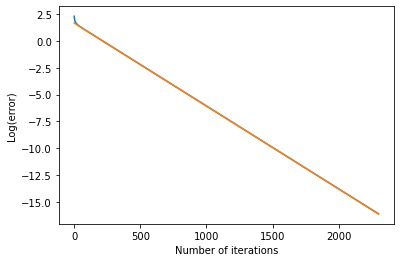

In [641]:
plt.plot(error_list)
plt.xlabel("Number of iterations")
plt.ylabel('Log(error)')
coef_1 = curve_fit(linear, np.arange(len(error_list)), error_list)[0]
print('Convergence rate = ' + str(coef_1[0]))
plt.plot(np.arange(len(error_list)), linear(np.arange(len(error_list)), *coef_1))

In [642]:
n_steps_list, error_gs_list = [], []
for relax_factor in np.arange(0.1, 2.1, 0.1):
    u_gs, u_exact, error_list, n_steps = Jacobi_GS(N_grid = 25, max_n_iter = 1000, source_positions=source_positions, tolerance = 1e-7, relax_factor = relax_factor, Jacobi = False)
    n_steps_list.append(n_steps)
    error_gs_list.append(error_list) 

the algotithm converged
the algotithm converged
the algotithm converged
the algotithm converged
the algotithm converged
the algotithm converged
the algotithm converged
the algotithm converged
the algotithm converged


In [644]:
rates = []
for i in range(20):
    rate = curve_fit(linear, np.arange(len(error_gs_list[i])), error_gs_list[i])[0][0]
    rates.append(rate)

Text(0, 0.5, 'Convergence rate of G-S')

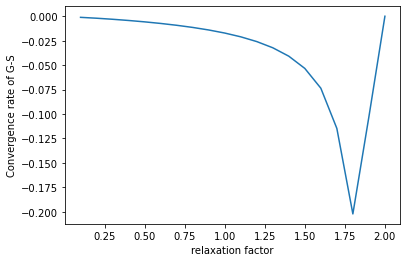

In [645]:
plt.plot(np.arange(0.1, 2.1, 0.1), rates)
plt.xlabel("relaxation factor")
plt.ylabel('Convergence rate of G-S')

As we can see from the plot above the optimal relaxation factor for the G-S method is 1.8.

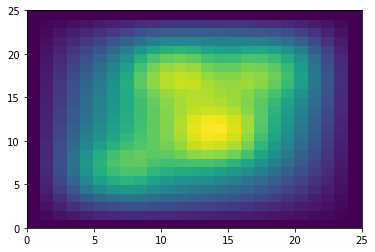

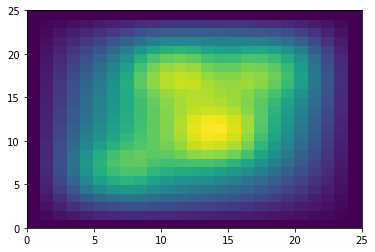

In [646]:
plt.pcolor(u_jacobi)
plt.show()
plt.pcolor(u_exact)
plt.show()

In [647]:
flux = '0.0000 0.0000 0.0000 0.0000 0.0122 0.0072 0.0122 0.0054 0.0244 0.0145 0.0244 0.0109 0.0361 0.0222 0.0360 0.0163 0.0466 0.0303 0.0463 0.0217 0.0552 0.0391 0.0548 0.0270 0.0612 0.0483 0.0605 0.0323 0.0643 0.0576 0.0633 0.0373 0.0649 0.0662 0.0635 0.0420 0.0636 0.0734 0.0618 0.0464 0.0611 0.0784 0.0590 0.0504 0.0583 0.0811 0.0561 0.0542 0.0553 0.0819 0.0533 0.0578 0.0522 0.0814 0.0507 0.0612 0.0489 0.0803 0.0483 0.0645 0.0452 0.0790 0.0459 0.0673 0.0411 0.0771 0.0431 0.0689 0.0367 0.0740 0.0399 0.0684 0.0319 0.0687 0.0360 0.0652 0.0268 0.0610 0.0315 0.0589 0.0216 0.0509 0.0262 0.0498 0.0162 0.0392 0.0202 0.0387 0.0108 0.0264 0.0138 0.0262 0.0054 0.0132 0.0070 0.0132 0.0000 0.0000 0.0000 0.0000'
flux = flux.split()
flux = [float(i) for i in flux]
flux = np.array(flux).reshape(-1, 4)
flux_1 = np.concatenate([flux[:, 0], flux[:, 1], flux[:, 2], flux[:, 3]])

In [648]:
def calc_flux(u, N_grid):
    dx = 1/(N_grid-1)
    #left
    flux_left = 0.5/dx * (- 3*u[0,:] + 4*u[1, :] - 1*u[2, :])
    flux_right = 0.5/dx * (3*u[-1,:] - 4*u[-2, :] + 1*u[-3, :])
    flux_bottom = 0.5/dx * (- 3*u[:,0] + 4*u[:, 1] - 1*u[:, 2])
    flux_top = 0.5/dx * (3*u[:,-1] - 4*u[:, -2] + 1*u[:, -3])
    flux = np.concatenate([flux_left, flux_right, flux_bottom, flux_top])
    return(flux)

In [649]:
f_num = -calc_flux(u_jacobi, 25)

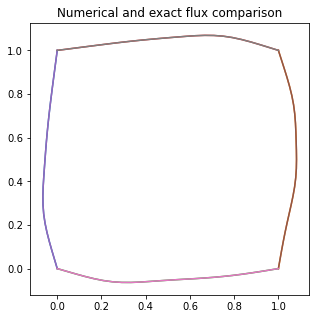

In [650]:
plt.figure(figsize = (5, 5))
plt.title('Numerical and exact flux comparison for Jacobi method')
plt.plot(-flux_1[:25], np.linspace(0, 1, 25))
plt.plot(flux[:, 1]+1, np.linspace(0, 1, 25))
plt.plot(np.linspace(0, 1, 25), -flux[:, 2])
plt.plot(np.linspace(0, 1, 25), flux[:, 3]+1)
plt.plot(f_num[:25], np.linspace(0, 1, 25))
plt.plot(f_num[25:50]+1, np.linspace(0, 1, 25))
plt.plot(np.linspace(0, 1, 25), f_num[50:75])
plt.plot(np.linspace(0, 1, 25), f_num[75:]+1)

the algotithm converged


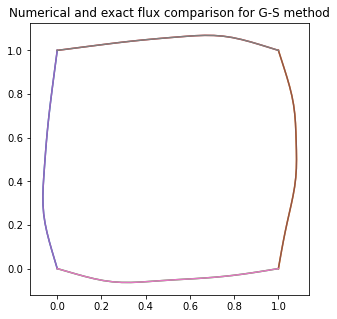

In [652]:
u_gs, u_exact, error_list, n_steps = Jacobi_GS(N_grid = 25, max_n_iter = 1000, source_positions=source_positions, tolerance = 1e-7, relax_factor = 1.8, Jacobi = False)
f_num = -calc_flux(u_gs, 25)
plt.figure(figsize = (5, 5))
plt.title('Numerical and exact flux comparison for G-S method')
plt.plot(-flux_1[:25], np.linspace(0, 1, 25))
plt.plot(flux[:, 1]+1, np.linspace(0, 1, 25))
plt.plot(np.linspace(0, 1, 25), -flux[:, 2])
plt.plot(np.linspace(0, 1, 25), flux[:, 3]+1)
plt.plot(f_num[:25], np.linspace(0, 1, 25))
plt.plot(f_num[25:50]+1, np.linspace(0, 1, 25))
plt.plot(np.linspace(0, 1, 25), f_num[50:75])
plt.plot(np.linspace(0, 1, 25), f_num[75:]+1)

As we can see from the plot for both solvers, our results are in good agreement with the provided solution.

### Two-grid method

In [653]:
def Jacobi_GS_2g(N_grid, init_guess, max_n_iter, source_positions, relax_factor, Jacobi = True):
    
    dx  = 1/(N_grid-1)

    # Create uniform grid in computational space
    x, y = np.meshgrid(np.linspace(0,1,N_grid), np.linspace(0,1,N_grid), indexing='ij')

    # Create map (i,j) -> I (index in global matrix)
    TotalNodes = N_grid*N_grid
    Node = np.arange(0,TotalNodes).reshape((N_grid,N_grid), order='F')

    # Allocate space for right hand side vector and global matrix.
    # Make sure to use a sparse matrix format (here we use list of lists (lil)
    u = init_guess
    f = np.zeros([N_grid, N_grid])
    A = lil_matrix((TotalNodes, TotalNodes))
    
    for i in range(1,N_grid-1):
        for j in range(1,N_grid-1):
            CN = Node[i,j]   # Current node

            # Calculate mapping coefficients
            c_xx = -1
            c_yy = -1

            # Stamp entries in global matrix
            A[CN, Node[i+1,j  ]] = A[CN, Node[i+1,j  ]] + 1/dx**2 * c_xx
            A[CN, Node[i  ,j  ]] = A[CN, Node[i  ,j  ]] - 2/dx**2 * c_xx - 2/dx**2 * c_yy
            A[CN, Node[i-1,j  ]] = A[CN, Node[i-1,j  ]] + 1/dx**2 * c_xx
            
            A[CN, Node[i  ,j+1]] = A[CN, Node[i  ,j+1]] + 1/dx**2 * c_yy
            
            A[CN, Node[i  ,j-1]] = A[CN, Node[i  ,j-1]] + 1/dx**2 * c_yy
            
    # Now boudnary conditions
    for i in range(N_grid):     # Bottom boundary
        CN = Node[i,0]

        A[CN, Node[i,0]] = A[CN, Node[i,0]] + 1

    for i in range(N_grid):     # Top boundary
        CN = Node[i,N_grid-1]
        A[CN, Node[i,N_grid-1]] = A[CN, Node[i,N_grid-1]] + 1
        
    for j in range(1,N_grid-1):  # Left boundary
        CN = Node[0,j]
        A[CN, Node[0,j]] = A[CN, Node[0,j]] + 1

    for j in range(1,N_grid-1):  # Right boundary
        
        CN = Node[N_grid-1,j]
        A[CN, Node[N_grid-1,j]] = A[CN, Node[N_grid-1,j]] + 1
    
    for pos in source_positions:
        n_x, n_y = pos[0], pos[1]
        for k in range((N_grid-1)//6+1):
            for l in range((N_grid-1)//6+1):
                f[n_x*(N_grid-1)//6 + k, n_y*(N_grid-1)//6 + l] = 1
                
    u_exact = spsolve(A.tocsr(),f.reshape(-1, 1)).reshape((N_grid, N_grid))
    
    error_list = []
    
    for i in range(max_n_iter):
        error = (((f.reshape(-1, 1) - A*u.reshape(-1, 1))**2).sum())**0.5
        error_list.append(np.log(error))
        if Jacobi:
            u[1:-1, 1:-1] = relax_factor*(0.25*(u[:-2, 1:-1]+u[2:, 1:-1]+u[1:-1, :-2]
                     + u[1:-1, 2:]+f[1:-1, 1:-1]*dx**2)) + (1-relax_factor)*u[1:-1, 1:-1]
        else: #Gauss-Seidel
            for i in range(1, N_grid-1):
                for j in range(1, N_grid-1):
                    u[i, j] = relax_factor*(0.25*(u[i+1, j]+u[i-1, j]+u[i, j+1]
                     + u[i, j-1]+f[i, j]*dx**2)) + (1-relax_factor)*u[i, j]
                
    return u, u_exact, error_list, A, f.reshape(-1, 1)

In [655]:
#for restriction I have used injection
def I_2h(r_h):
    return(r_h[::2])

In [654]:
#for prolongation I have used interpolation
def I_h(r_2h):
    r_h = np.zeros((len(r_2h)-1)*2 + 1)
    r_h[::2] = r_2h
    r_h[1::2] = 0.5*(r_2h[:-1] + r_2h[1:])
    return(r_h)

In [656]:
def two_grid_method(N_grid, init_guess, nu_1, nu_2, source_positions, relax_factor, Jacobi = True):
    u, u_exact, error_list, A_h, f = Jacobi_GS_2g(N_grid, init_guess, nu_1, 
                                                source_positions, relax_factor, Jacobi)
    r_h = f - A_h @ u.reshape(-1, 1)
    r_2h = I_2h(r_h)
    A_2h = A_h[::2, ::2]
    e_2h = spsolve(A_2h.tocsr(), r_2h)
    e_h = I_h(e_2h)
    u[1:-1, 1:-1] = u[1:-1, 1:-1] + e_h.reshape(N_grid, N_grid)[1:-1, 1:-1]
    u, u_exact, error_list, A, f = Jacobi_GS_2g(N_grid, u, nu_2, 
                                                source_positions, relax_factor, Jacobi = Jacobi)
    return(u, u_exact, error_list[-1])

In [657]:
def full_two_grid(N_grid, init_guess, nu_1, nu_2, nu_c, source_positions, relax_factor, Jacobi = True):
    local_init_guess = init_guess
    error_full_list = []
    for i in range(nu_c):
        n_step = nu_c
        u, u_exact, error_full = two_grid_method(N_grid, local_init_guess, nu_1, nu_2, source_positions, relax_factor, Jacobi = Jacobi)
        local_init_guess = u
        error_full_list.append(error_full)
        if np.exp(error_full_list[-1]) < 1e-7:
            n_step = i
            print("we converged!")
            break
    return(u, u_exact, error_full_list)

In [658]:
source_positions_init = [1, 7, 14, 16]
source_positions = []
for pos in source_positions_init:
    source_positions.append(((pos-1)//4+1, (pos-1)%4+1))
#print(source_positions)
u, u_exact, error_full_list = full_two_grid(N_grid = 25, init_guess = np.zeros([25, 25]), nu_1 = 5, nu_2 = 5, nu_c = 1000, source_positions = source_positions, relax_factor = 0.5, Jacobi = True)

we converged!


Convergence rate = -0.051456228197299565


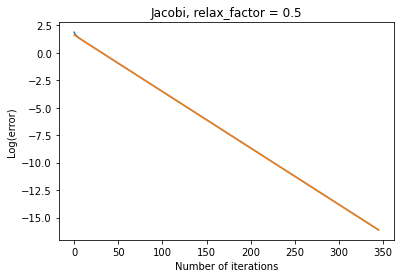

In [662]:
plt.title('Jacobi, relax_factor = 0.5')
plt.plot(error_full_list)
plt.xlabel("Number of iterations")
plt.ylabel('Log(error)')
coef_1 = curve_fit(linear, np.arange(len(error_full_list)), error_full_list)[0]
print('Convergence rate = ' + str(coef_1[0]))
plt.plot(np.arange(len(error_full_list)), linear(np.arange(len(error_full_list)), *coef_1))

In [663]:
u, u_exact, error_full_list = full_two_grid(N_grid = 25, init_guess = np.zeros([25, 25]), nu_1 = 5, nu_2 = 5, nu_c = 1000, source_positions = source_positions, relax_factor = 0.8, Jacobi = True)

we converged!


Convergence rate = -0.0772748093871456


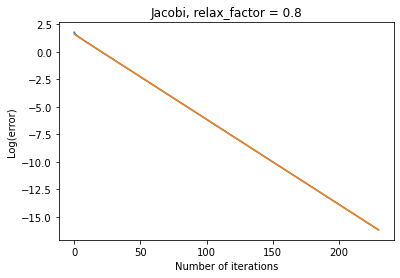

In [664]:
plt.title('Jacobi, relax_factor = 0.8')
plt.plot(error_full_list)
plt.xlabel("Number of iterations")
plt.ylabel('Log(error)')
coef_1 = curve_fit(linear, np.arange(len(error_full_list)), error_full_list)[0]
print('Convergence rate = ' + str(coef_1[0]))
plt.plot(np.arange(len(error_full_list)), linear(np.arange(len(error_full_list)), *coef_1))

In [665]:
u, u_exact, error_full_list = full_two_grid(N_grid = 25, init_guess = np.zeros([25, 25]), nu_1 = 5, nu_2 = 5, nu_c = 1000, source_positions = source_positions, relax_factor = 0.5, Jacobi = False)

we converged!


Convergence rate = -0.06564199874820122


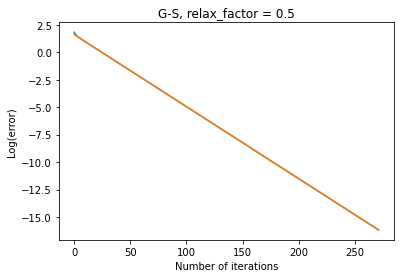

In [666]:
plt.title('G-S, relax_factor = 0.5')
plt.plot(error_full_list)
plt.xlabel("Number of iterations")
plt.ylabel('Log(error)')
coef_1 = curve_fit(linear, np.arange(len(error_full_list)), error_full_list)[0]
print('Convergence rate = ' + str(coef_1[0]))
plt.plot(np.arange(len(error_full_list)), linear(np.arange(len(error_full_list)), *coef_1))

In [667]:
u, u_exact, error_full_list = full_two_grid(N_grid = 25, init_guess = np.zeros([25, 25]), nu_1 = 5, nu_2 = 5, nu_c = 1000, source_positions = source_positions, relax_factor = 0.8, Jacobi = False)

we converged!


Convergence rate = -0.1228305101574239


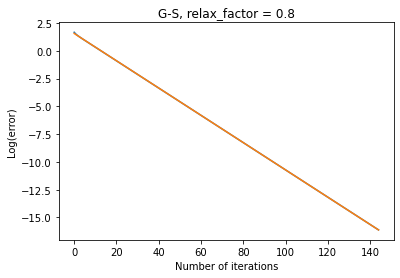

In [668]:
plt.title('G-S, relax_factor = 0.8')
plt.plot(error_full_list)
plt.xlabel("Number of iterations")
plt.ylabel('Log(error)')
coef_1 = curve_fit(linear, np.arange(len(error_full_list)), error_full_list)[0]
print('Convergence rate = ' + str(coef_1[0]))
plt.plot(np.arange(len(error_full_list)), linear(np.arange(len(error_full_list)), *coef_1))

After comparing the convergence rates we can say that Gauss-Seidel on the multigrid is the best method. Relaxation factor of 0.8 is better for both Jacobi and G-S.

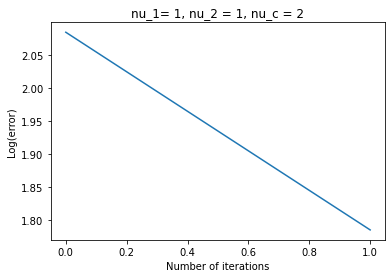

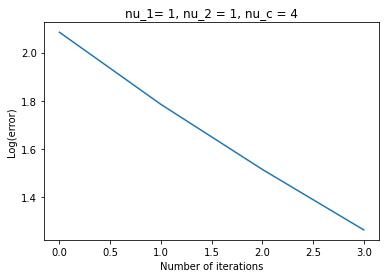

we converged!


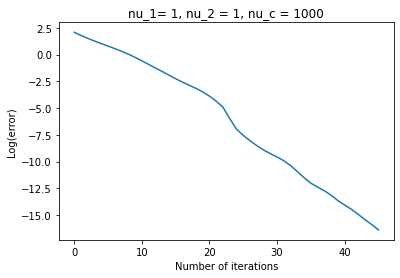

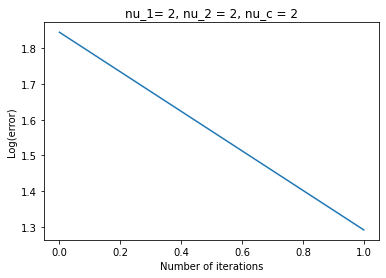

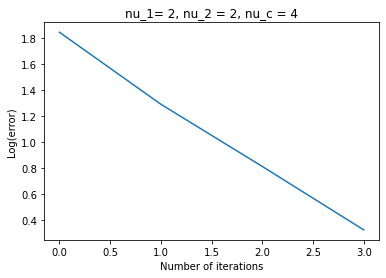

we converged!


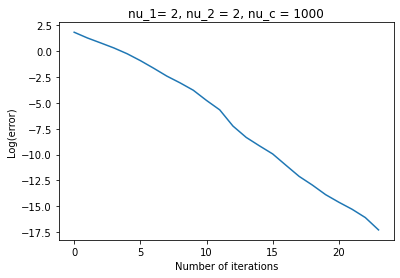

In [672]:
for nu_1 in [1, 2]:
    nu_2 = nu_1 
    for nu_c in [2, 4, 1000]:
        u, u_exact, error_full_list = full_two_grid(N_grid = 25, init_guess = np.zeros([25, 25]), nu_1 = nu_1, nu_2 = nu_2, nu_c = nu_c, source_positions = source_positions, relax_factor = 1.8, Jacobi = False)
        plt.plot(error_full_list)
        plt.title('nu_1= {}, nu_2 = {}, nu_c = {}'.format(nu_1, nu_2, nu_c))
        plt.xlabel("Number of iterations")
        plt.ylabel('Log(error)')
        plt.show()

As we increase nu_1 and nu_2, the rate of convergence increases.

In [673]:
flux = '0.0000 0.0000 0.0000 0.0000 0.0084 0.0076 0.0086 0.0042 0.0165 0.0152 0.0173 0.0084 0.0243 0.0228 0.0264 0.0126 0.0314 0.0303 0.0360 0.0167 0.0377 0.0378 0.0461 0.0207 0.0431 0.0451 0.0565 0.0245 0.0472 0.0523 0.0668 0.0281 0.0501 0.0593 0.0761 0.0315 0.0517 0.0659 0.0833 0.0346 0.0520 0.0721 0.0877 0.0373 0.0511 0.0774 0.0888 0.0396 0.0492 0.0810 0.0867 0.0413 0.0464 0.0823 0.0823 0.0425 0.0430 0.0808 0.0761 0.0430 0.0391 0.0762 0.0690 0.0427 0.0349 0.0690 0.0615 0.0416 0.0305 0.0601 0.0539 0.0394 0.0260 0.0504 0.0461 0.0362 0.0216 0.0407 0.0384 0.0320 0.0172 0.0316 0.0307 0.0268 0.0128 0.0230 0.0230 0.0208 0.0085 0.0150 0.0153 0.0142 0.0043 0.0074 0.0076 0.0072 0.0000 0.0000 0.0000 0.0000'
flux = flux.split()
flux = [float(i) for i in flux]
flux = np.array(flux).reshape(-1, 4)
flux_1 = np.concatenate([flux[:, 0], flux[:, 1], flux[:, 2], flux[:, 3]])

In [674]:
from itertools import combinations
s_p = np.arange(1, 17)
for source_positions_init in combinations(s_p, 4):
    source_positions = []
    for pos in source_positions_init:
        source_positions.append(((pos-1)//4+1, (pos-1)%4+1))
#print(source_positions)
    u, u_exact, error_full_list = full_two_grid(N_grid = 25, init_guess = np.zeros([25, 25]), nu_1 = 2, nu_2 = 2, nu_c = 100, source_positions = source_positions, relax_factor = 1.8, Jacobi = False)
    flux_num = calc_flux(u, 25)
    error = (((abs(flux_num)-abs(flux_1))**2).sum())**0.5
    if error < 1e-3:
        print(source_positions_init)
        break

we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we con

we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we con

we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we converged!
we con

Text(0.5, 1.0, 'Source map')

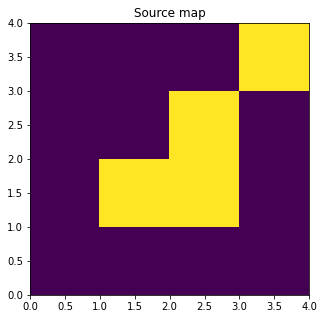

In [682]:
source_map = np.zeros(16)
plt.figure(figsize=(5, 5))
for i in [5, 6, 10, 15]:
    source_map[i] = 1
source_map = source_map.reshape(4, 4)
plt.pcolor(source_map)
plt.title('Source map')